## Modyle: Heston & Fourier

Using the Fourier transform of pseudo-probabilities $P_j$.

In [ ]:
# Heston characteristic function.
# Inputs:
# S_0: stock price
# V_0: V_0 initial variance (V_0^2 = initial volatility)
# theta: long-term variance mean
# kappa: variance mean-reversion speed
# sigma: volatility of the variance process
# r : risk-free rate
# rho: correlation between the Wiener processes for the stock price and its variance
# K: option strike
# a: starting point
# b: end point
# n: number of interation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cmath as c

from math import pi

Heston 's characteristic function

In [ ]:
def HestonCharacteristicFunction (S_0, V_0, tau, kappa, theta, sigma, rho, r, u, j):
    # tau -- time to maturity
    alpha = - u*u/2 - 1j*u/2 + 1j*j*u
    beta = kappa - rho*sigma*u*1j - rho*sigma*j
    gamma = sigma*sigma/2;

    d = c.sqrt(beta*beta - 4*alpha*gamma)

    r_plus = (beta + d)/(gamma*2)
    r_minus = (beta - d)/(gamma*2)
    
    g = r_minus/r_plus

    C = kappa * (r_minus * tau - (2/(sigma**2)) * c.log((1 - g * c.exp(-d*tau))/(1-g)))
    D = r_minus * (1 - c.exp(-d * tau))/(1 - g * c.exp(-d * tau))

    # characteristic function is evaluated at points u
    result = ( c.exp(C*theta + D*V_0 + 1j*u*c.log(S_0*c.exp(r*tau)/K)) / (1j*u)).real

    return result

Integral calculation

In [ ]:
def integral (S_0, V_0, tau, kappa, theta, sigma, rho, r, K, j, a, b, n):

    h = (b-a)/float(n)
    total = 0
    
    for k in range(1, n):
        total += HestonCharacteristicFunction(S_0, V_0, tau, kappa, theta, sigma, rho, r, (a + (k*h)), j)

    result = h * total
    return result

Call Option Calculation

In [ ]:
def HestonCallOption (S_0, V_0, tau, kappa, theta, sigma, rho, r, K, a, b, n):
    # computing pi_0
    int_0 = integral(S_0, V_0, tau, kappa, theta, sigma, rho, r, K, 0, a, b, n)
    pi_0 = 0.5+int_0/c.pi

    # computing pi_1
    int_1 = (integral(S_0, V_0, tau, kappa, theta, sigma, rho, r, K, 1, a, b, n)).real
    pi_1 = 0.5+int_1/c.pi

    result = ( K*(S_0*c.exp(r*tau)*pi_1/K - pi_0) ).real
    
    return result 

In [ ]:
# Heston characteristic function.
# Inputs:
# S_0: stock price
# V_0: V_0^2 initial variance (V_0^2 = initial volatility)
# theta: long-term variance mean
# kappa: variance mean-reversion speed
# sigma: volatility of the variance process
# r : risk-free rate
# rho: correlation between the Weiner processes for the stock price and its variance
# K: option strike
# a: starting point
# b: end point
# n: number of interation
S_0 = 100
V_0 = 0.04
tau = 0.5
kappa = 2
theta = 0.04
sigma = 0.5
rho = -0.7
r = 0.03
K = 90
a = 0
b = 100
n = 100000

In [ ]:
test_2 = HestonCallOption(S_0, V_0, tau, kappa, theta, sigma, rho, r, K, a, b, n)
                         #S_0, V_0, tau, kappa, theta, sigma, rho, r, K
test_2

13.40130067428879

## Modyle: Heston & Monte Carlo

In [ ]:
# Inputs:
# S_0: initial asset price
# V_0: initial volatility (v0^2 initial variance)
# theta: long-term variance mean
# kappa: variance mean-reversion speed
# sigma: vvolatility of volatility :)
# r : risk-free rate
# rho: correlation between the Weiner processes for the stock price and its variance
# K: option strike
# a: starting point
# b: end point
# n: number of interation
# numPaths: number of paths
# dt: size of time-step
# T_max: the longest maturity
#Exercise = np.arange(0.1, 2, 0.1).tolist()
#Maturity = np.arange(0.5, T_max+0.25, 0.25).tolist()
#ImpVolTable = np.zeros((len(Exercise), len(Maturity)))

In [ ]:
import numpy as np
from math import exp, log, sqrt, pi

In [ ]:
def Simulation (scheme, negvar, numPaths, rho, S_0, V_0, T, kappa, theta, sigma, r, q):
    # negvar -- 'Reflect' or 'Truncate'
    # q can be skipped (dividends)
    num_time = int(T/dt) 
    S = np.zeros((num_time+1, numPaths)) 
    S[0,:] = S_0
    V = np.zeros((num_time+1, numPaths))
    V[0,:] = V_0
    V_count_of_0 = 0 # when scheme go negative
    for i in range(numPaths):
        for t_step in range(1, num_time+1):
            # the 2 stochastic BM for variance V and asset price S are correlated
            # the correlation is equils to rho        
            Zv = np.random.randn(1)
            Zs = rho*Zv + sqrt(1-rho**2)*np.random.randn(1)
            # choose Euler scheme (Euler discretization scheme)
            # one can choose another scheme
            if scheme == 'Euler':
                V[t_step,i] =  V[t_step-1,i] + kappa * (theta-V[t_step-1,i])*dt + sigma * sqrt(V[t_step-1,i]) * sqrt(dt) * Zv 
            # Milstein discretization scheme
            if scheme == 'Milstein':
                V[t_step,i] = V[t_step-1,i] + kappa * (theta-V[t_step-1,i])*dt + sigma * sqrt(V[t_step-1,i]) * sqrt(dt) * Zv \
                + 1/4 *sigma**2*dt*(Zv**2 -1)

            # scheme can go negative with positive probability and that is the main issue with this scheme
            # so we need to reflect or truncate
            if V[t_step,i] <= 0:
                V_count_of_0 = V_count_of_0+1
                if negvar == 'Reflect':
                    V[t_step,i] = abs(V[t_step,i])
                elif negvar == 'Truncate':
                    V[t_step,i] = max(V[t_step,i] , 0)
                    
            
            # now do the simluations for asset price S
            S[t_step,i] = S[t_step-1,i] * np.exp((r-q-V[t_step-1,i]/2)*dt + sqrt(V[t_step-1,i])*sqrt(dt)* Zs)
    return S, V, V_count_of_0

Calculate the option price.

In [ ]:
def Price(scheme, negvar, numPaths, typeOption, rho, S_0 , V_0, T_max, kappa, theta, sigma, r, q, Maturity, Exercise):
    OptionPriceMatrix = np.zeros((len(Exercise),len(Maturity)))
    stdErrTable = np.zeros((len(Exercise),len(Maturity)))

    # take the simulated stock price S and simulated variance V
    S, V, V_count_of_0 = Simulation (scheme, negvar, numPaths, rho, S_0 , V_0, T_max, kappa, theta, sigma, r, q)
    for i in range(len(Maturity)):
        T_tmp = Maturity[i]
        T_row = int(T_tmp/dt)
        # terminal stock prices at different time T
        S_T = S[T_row,:]
        
        for j in range(len(Exercise)):
            K = Exercise[j]
            # payoff vectors
            if typeOption == 'Put':
                Payoff = [max(K - x,0) for x in S_T]
            elif typeOption == 'Call':
                Payoff = [max(x - K,0) for x in S_T]
            SimPrice = np.exp(-r* T_tmp )*np.mean(Payoff)
            OptionPriceMatrix[j][i] = SimPrice
            stdDev = np.std(Payoff, dtype=np.float64)
            stdErr = stdDev/sqrt(numPaths)
            stdErrTable[j][i] = stdErr 
    return S, V, V_count_of_0, OptionPriceMatrix, stdErrTable, Payoff

Set the values of the Heston model parameters.

In [ ]:
numPaths = 1000     # number of paths
rho = -0.02         # correlation of the bivariables of two BM W_1 and W_2 in model
S_0 = 1             # initial asset price
V_0 = 0.04          # initial variance
kappa = 2           # mean-reversion rate 
theta = 0.04        # long-run variance
sigma = 0.1         # volatility of volatility :)
r = 0.01            # risk-free interest rate
q = 0.0             # dividend (we skip this)
dt = 0.001          # size of time-step 
T_max = 3           # the longest maturity 
Exercise = np.arange(0.1, 2, 0.1).tolist()
Maturity = np.arange(0.5, T_max+0.25, 0.25).tolist()
ImpVolTable = np.zeros((len(Exercise), len(Maturity)))

Now plot the simulations.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Text(0.09379629152477455, 0.012566320283548623, 'Option price')

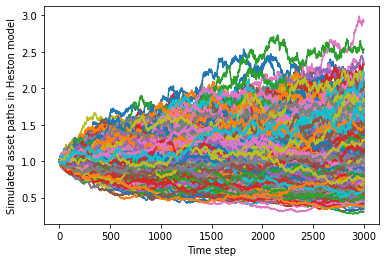

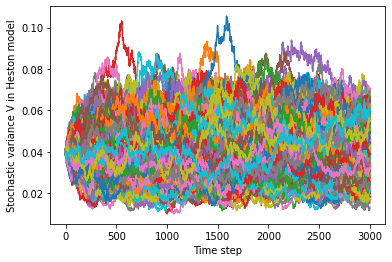

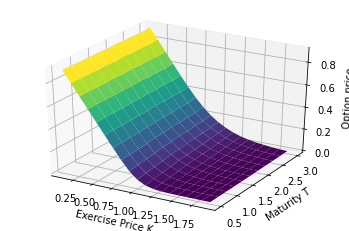

In [ ]:
(S, V, V_count_of_0, OptionPriceMatrix, stdErrTable, Payoff) = \
Price('Euler', 'Truncate', numPaths, 'Call', rho, S_0, V_0, T_max, kappa, theta, sigma, r, q, Maturity, Exercise)

for i in range(len(Maturity)):
    Tvalue = Maturity[i]
    for j in range(len(Exercise)):
        K = Exercise[j]
        P_true = OptionPriceMatrix[j][i]

plt.close()

fig = plt.figure(1)
plt.plot(S)
plt.savefig('asset_paths.png')
plt.ylabel('Simulated asset paths in Heston model')
plt.xlabel('Time step')

fig = plt.figure(2)
plt.plot(V)
plt.savefig('stoch_var.png')
plt.ylabel('Stochastic variance V in Heston model')
plt.xlabel('Time step')

fig = plt.figure(3)
ax = plt.axes(projection='3d')
xx, yy = np.meshgrid(Exercise, Maturity)
ax.plot_surface(xx, yy, OptionPriceMatrix.T, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
plt.savefig('surface.png')
ax.set_xlabel('Exercise Price K')
ax.set_ylabel('Maturity T')
ax.set_zlabel('Option price')

## Modyle: Heston & Hedging

In [ ]:
import numpy as np
from math import exp, log, sqrt, pi

In [ ]:
def Simulation (scheme, negvar, numPaths, rho, S_0, V_0, T, kappa, theta, sigma, r, q):
    # negvar -- 'Reflect' or 'Truncate'
    # q can be skipped (dividends)
    num_time = int(T/dt) 
    S = np.zeros((num_time+1, numPaths)) 
    S[0,:] = S_0
    V = np.zeros((num_time+1, numPaths))
    V[0,:] = V_0
    V_count_of_0 = 0 # when scheme go negative
    for i in range(numPaths):
        for t_step in range(1, num_time+1):
            # the 2 stochastic BM for variance V and asset price S are correlated
            # the correlation is equils to rho        
            Zv = np.random.randn(1)
            Zs = rho*Zv + sqrt(1-rho**2)*np.random.randn(1)
            # choose Euler scheme (Euler discretization scheme)
            # one can choose another scheme
            if scheme == 'Euler':
                V[t_step,i] =  V[t_step-1,i] + kappa * (theta-V[t_step-1,i])*dt + sigma * sqrt(V[t_step-1,i]) * sqrt(dt) * Zv 
            # Milstein discretization scheme
            if scheme == 'Milstein':
                V[t_step,i] = V[t_step-1,i] + kappa * (theta-V[t_step-1,i])*dt + sigma * sqrt(V[t_step-1,i]) * sqrt(dt) * Zv \
                + 1/4 *sigma**2*dt*(Zv**2 -1)

            # scheme can go negative with positive probability and that is the main issue with this scheme
            # so we need to reflect or truncate
            if V[t_step,i] <= 0:
                V_count_of_0 = V_count_of_0+1
                if negvar == 'Reflect':
                    V[t_step,i] = abs(V[t_step,i])
                elif negvar == 'Truncate':
                    V[t_step,i] = max(V[t_step,i] , 0)
                    
            
            # now do the simluations for asset price S
            S[t_step,i] = S[t_step-1,i] * np.exp((r-q-V[t_step-1,i]/2)*dt + sqrt(V[t_step-1,i])*sqrt(dt)* Zs)
    return S, V, V_count_of_0

Calculate the option price.

In [ ]:
def Price(scheme, negvar, numPaths, typeOption, rho, S_0 , V_0, T_max, kappa, theta, sigma, r, q, Maturity, Exercise):
    OptionPriceMatrix = np.zeros((len(Exercise),len(Maturity)))
    stdErrTable = np.zeros((len(Exercise),len(Maturity)))

    # take the simulated stock price S and simulated variance V
    S, V, V_count_of_0 = Simulation (scheme, negvar, numPaths, rho, S_0 , V_0, T_max, kappa, theta, sigma, r, q)
    for i in range(len(Maturity)):
        T_tmp = Maturity[i]
        T_row = int(T_tmp/dt)
        # terminal stock prices at different time T
        S_T = S[T_row,:]
        
        for j in range(len(Exercise)):
            K = Exercise[j]
            # payoff vectors
            if typeOption == 'Put':
                Payoff = [max(K - x,0) for x in S_T]
            elif typeOption == 'Call':
                Payoff = [max(x - K,0) for x in S_T]
            SimPrice = np.exp(-r* T_tmp )*np.mean(Payoff)
            OptionPriceMatrix[j][i] = SimPrice
            stdDev = np.std(Payoff, dtype=np.float64)
            stdErr = stdDev/sqrt(numPaths)
            stdErrTable[j][i] = stdErr 
    return S, V, V_count_of_0, OptionPriceMatrix, stdErrTable, Payoff

Set the values of the Heston model parameters.

In [ ]:
numPaths = 1     # number of paths
rho = -0.02         # correlation of the bivariables of two BM W_1 and W_2 in model
S_0 = 1             # initial asset price
V_0 = 0.04          # initial variance
kappa = 2           # mean-reversion rate 
theta = 0.04        # long-run variance
sigma = 0.1         # volatility of volatility :)
r = 0.01            # risk-free interest rate
q = 0.0             # dividend (we skip this)
dt = 0.001          # size of time-step 
T_max = 3           # the longest maturity 
Exercise = np.arange(0.1, 2, 0.1).tolist()
Maturity = np.arange(0.5, T_max+0.25, 0.25).tolist()
ImpVolTable = np.zeros((len(Exercise), len(Maturity)))

Now plot the simulations.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

Now we generate only one path with Monte Carlo.

Text(0.5, 0, 'Option price')

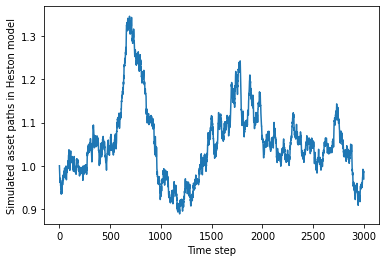

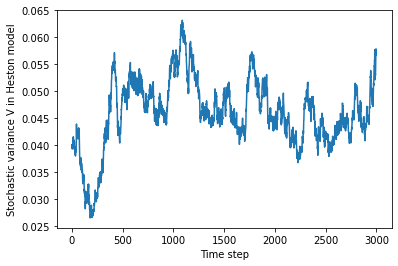

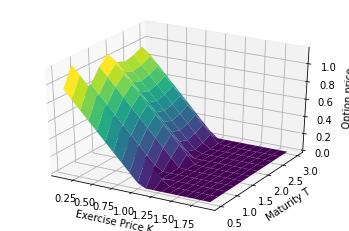

In [ ]:
(S, V, V_count_of_0, OptionPriceMatrix, stdErrTable, Payoff) = \
Price('Euler', 'Truncate', numPaths, 'Call', rho, S_0, V_0, T_max, kappa, theta, sigma, r, q, Maturity, Exercise)

for i in range(len(Maturity)):
    Tvalue = Maturity[i]
    for j in range(len(Exercise)):
        K = Exercise[j]
        P_true = OptionPriceMatrix[j][i]

plt.close()

fig = plt.figure(1)
plt.plot(S)
plt.ylabel('Simulated asset paths in Heston model')
plt.xlabel('Time step')

fig = plt.figure(2)
plt.plot(V)
plt.ylabel('Stochastic variance V in Heston model')
plt.xlabel('Time step')

fig = plt.figure(3)
ax = plt.axes(projection='3d')
xx, yy = np.meshgrid(Exercise, Maturity)
ax.plot_surface(xx, yy, OptionPriceMatrix.T, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('Exercise Price K')
ax.set_ylabel('Maturity T')
ax.set_zlabel('Option price')

The price process S.

In [ ]:
S

array([[1.        ],
       [0.99466844],
       [0.99461029],
       ...,
       [0.98515415],
       [0.98761759],
       [0.96960907]])

Take another initial values.

In [ ]:
numPaths = 1     # number of paths
rho = -0.7         # correlation of the bivariables of two BM W_1 and W_2 in model
S_0 = 100           # initial asset price
V_0 = 0.04          # initial variance
kappa = 2           # mean-reversion rate 
theta = 0.04        # long-run variance
sigma = 0.5         # volatility of volatility :)
r = 0.03            # risk-free interest rate
q = 0.0             # dividend (we skip this)
dt = 0.1            # size of time-step 
T_max = 0.5           # the longest maturity 
Exercise = np.arange(90, 91, 2).tolist()
#Exercise = np.arange(0.1, 2, 0.1).tolist()
Maturity = np.arange(0.5, T_max+0.25, 0.25).tolist()
ImpVolTable = np.zeros((len(Exercise), len(Maturity)))

Text(0.5, 0, 'Time step')

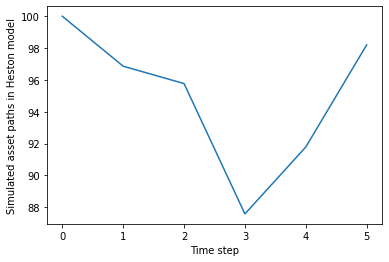

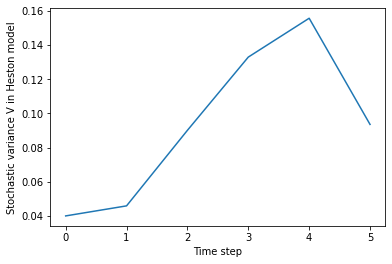

In [ ]:
(S, V, V_count_of_0, OptionPriceMatrix, stdErrTable, Payoff) = \
Price('Euler', 'Truncate', numPaths, 'Call', rho, S_0, V_0, T_max, kappa, theta, sigma, r, q, Maturity, Exercise)

for i in range(len(Maturity)):
    Tvalue = Maturity[i]
    for j in range(len(Exercise)):
        K = Exercise[j]
        P_true = OptionPriceMatrix[j][i]

plt.close()

fig = plt.figure(1)
plt.plot(S)
plt.ylabel('Simulated asset paths in Heston model')
plt.xlabel('Time step')

fig = plt.figure(2)
plt.plot(V)
plt.ylabel('Stochastic variance V in Heston model')
plt.xlabel('Time step')

For example, we have 5 steps. The price process S has 6 element: initial value and values in 5 steps.

In [ ]:
S

array([[100.        ],
       [ 96.86250007],
       [ 95.77218854],
       [ 87.58698496],
       [ 91.78774439],
       [ 98.20124872]])

The last value is S[5].

In [ ]:
S[5]

array([98.20124872])

In [ ]:
def Calculate_Pi_1 (S_0, V_0, tau, kappa, theta, sigma, rho, r, K, a, b, n):
    # computing pi_1
    int_1 = (integral(S_0, V_0, tau, kappa, theta, sigma, rho, r, K, 1, a, b, n)).real
    pi_1 = 0.5+int_1/c.pi
    
    return pi_1 

Put the initial values for portfolio.

In [ ]:
C_0 = HestonCallOption (S_0, V_0, tau, kappa, theta, sigma, rho, r, K, a, b, n)
d_t = 0
dt

0.1

In [ ]:
delta_0 = Calculate_Pi_1 (S_0, V_0, tau, kappa, theta, sigma, rho, r, K, a, b, n)
delta_0

0.858712267770126

In [ ]:
B_0 = C_0-delta_0*S_0
B_0

-72.4699261027238

Initialize value of steps.

In [ ]:
N = T_max / dt # N - amount of steps
N

5.0

Now solve the equation for portfolio.

In [ ]:
iter = 0

while d_t < T_max:
    d_t = d_t + dt;
    iter += 1
    S_dt = S[iter]
    V_dt = V[iter]
    delta_dt = Calculate_Pi_1 (S_dt, V_dt, tau-d_t, kappa, theta, sigma, rho, r, K, a, b, n)
    B_dt = delta_0*S_dt+B_0*c.exp(r*d_t)-delta_dt*S_dt
    B_0 = B_dt
    delta_0 = delta_dt

In [ ]:
iter

5

Notice, that the last value is in step equals to "iter".

In [ ]:
Pi_T = delta_0*S[iter]+B_0*c.exp(r*d_t)
Pi_T.real

array([5.90640327])

In [ ]:
def Max(a, b):
    if a > b:
        return a - b
    else:
        return 0

In [ ]:
PNL = Pi_T - Max(S[iter],K)
PNL.real

array([-2.29484545])

## Module: interactivity

In [ ]:
from ipywidgets import interact
from ipywidgets import widgets

In [ ]:
def plot_all(type_: str = 'Call',
             time_to_expiration: float = 0.25,
             volatility: float = 0.1587,
             stock_price: float = 100.0,
             interest_rate: float = 0.0):
    opt = StockOption(strike_price=np.linspace(20, 200, 100),
                      expiration_time=time_to_expiration,
                      is_call=(type_ == 'Call'))
    state = MarketState(stock_price=stock_price,
                        volatility=volatility,
                        interest_rate=interest_rate)
    
    data = {
        'price': price(opt, state),
        'delta': delta(opt, state),
        'gamma': gamma(opt, state),
        'vega': vega(opt, state),
        'theta': theta(opt, state),
        'rho': rho(opt, state)
    }

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    for name, ax in zip(data, axs.flatten()):
        ax.plot(opt.strike_price, data[name])
        ax.set_title(name)
        ax.set_xlabel('Strike price')
        
    plt.show()

In [ ]:
interact(plot_all,
         type_=widgets.Dropdown(options=['Call', 'Put'], value='Call', description='Option type'),
         time_to_expiration=widgets.FloatSlider(min=0.01, max=5.0, step=0.01, value=0.25, description='Time to expiration, years'),
         volatility=widgets.FloatSlider(min=0.1, max=2.0, step=0.01, value=0.1587, description='Volatility, annualized'),
         stock_price=widgets.FloatSlider(min=50.0, max=150.0, value=100.0, description='Stock price'),
         interest_rate=widgets.FloatSlider(min=0, max=0.2, step=0.005, value=0.0, description='Interest rate, annualized'));

interactive(children=(Dropdown(description='Option type', options=('Call', 'Put'), value='Call'), FloatSlider(…